In [ ]:
import numpy as np
import torch
import torch.nn as nn

# Network on 7/11

### Affinity from Flow

In [ ]:
import torch.nn.functional as F
def affinity_from_flow(flows, directions_array, flow_strength = 1, sigma=1):
  """Compute probabilities of transition in the given directions based on the flow. 

  Parameters
  ----------
  flows : torch tensor of shape n_points x n_dims
      _description_
  directions_array : torch tensor of shape n_directions x n_points x n_dims. Assumed to be normalized.
      _description_
  sigma : int, optional
      kernel bandwidth, by default 1
  returns (n_points)
  """
  assert len(flows.shape) == 2 # flows should only have one dimension
  assert len(directions_array.shape) > 1 and len(directions_array.shape) < 4
  n_directions = directions_array.shape[0]
  # Normalize directions
  length_of_directions = torch.linalg.norm(directions_array,dim=-1)
  normed_directions = F.normalize(directions_array,dim=-1)
  # and normalize flows # TODO: Perhaps reconsider
  # Calculate flow lengths, used to scale directions to flow
  flow_lengths = torch.linalg.norm(flows,dim=-1)
  if len(directions_array) == 1: # convert to 2d array if necessary
    directions_array = directions_array[:,None] 
  # scale directions to have same norm as flow
  # scaled_directions = normed_directions * flow_lengths[:,None].repeat(directions_array.shape[0],1,directions_array.shape[2])
  # compute dot products as matrix multiplication
  dot_products = (normed_directions * flows).sum(-1)
  # take distance between flow projected onto direction and the direction
  distance_from_flow = (torch.linalg.norm(flows,dim=1)).repeat(n_directions,1) - dot_products
  # take absolute value
  distance_from_flow = torch.abs(distance_from_flow)
  # print('shape of dff',distance_from_flow.shape)
  # add to this the length of each direction
  distance_from_flow = flow_strength*distance_from_flow + length_of_directions
  # put the points on rows, directions in columns
  distance_from_flow = distance_from_flow.T
  # take kernel of distances
  kernel =  torch.exp(-distance_from_flow/sigma)
  # normalize kernel
  # kernel /= torch.sum(kernel,axis=1)
  return kernel

### Affinity Matrix from Pointset to Pointset

In [ ]:
def affinity_matrix_from_pointset_to_pointset(pointset1, pointset2, flows,n_neighbors=None,sigma=0.5, flow_strength=1):
  """Compute affinity matrix between the points of pointset1 and pointset2, using the provided flow.

  Parameters
  ----------
  pointset1 : torch tensor, n1 x d
      The first pointset, to calculate affinities *from*
  pointset2 : torch tensor, n2 x d
      The second pointset, to calculate affinities *to* (from pointset1)
  flow : a function that, when called at a point, gives the flow at that point
  n_neighbors : number of neighbors to include in affinity computations. All neighbors beyond it are given affinity zero
  (currently not implemented)

  Returns:
  Affinity matrix: torch tensor of shape n1 x n2
  """
  # Calculate the directions from point i in pointset 1 to point j in pointset 2
  n1 = pointset1.shape[0]
  n2 = pointset2.shape[0]
  P2 = pointset2[:,:,None].repeat(1,1,n1)
  P1 = pointset1.T.repeat(n2,1,1)
  P3 = (P2 - P1)
  P3 = P3.transpose(1,2)
  # compute affinities from flows and directions
  affinities = affinity_from_flow(flows,P3,sigma=sigma,flow_strength=flow_strength)
  return affinities

### Gaussian Vector Field

In [ ]:
class GaussianVectorField(nn.Module):
  def __init__(self,n_dims, n_gaussians, device):
    super(GaussianVectorField, self).__init__()
    self.n_dims = n_dims
    # each gaussian has a mean and a variance, which are initialized randomly, but
    # are afterwards tuned by the network
    self.means = torch.nn.Parameter(torch.rand(n_gaussians,n_dims)*8 - 4).to(device)
    vecs = torch.randn(n_gaussians,n_dims)
    
    vecs = vecs / torch.linalg.norm(vecs, dim=1)[:,None]
    self.vectors = torch.nn.Parameter(vecs).to(device)
  def forward(self,points):
    # evaluates the vector field at each point
    # First, take distances between the points and the means
    dist_between_pts_and_means = torch.cdist(points,self.means)
    # print("distances between points and means",dist_between_pts_and_means)
    # apply kernel to this
    # creates n_points x n_means array
    kernel_from_mean = torch.exp(-(dist_between_pts_and_means**2))
    # print("kernalized",kernel_from_mean)
    # multiply kernel value by vectors associated with each Gaussian
    kernel_repeated = kernel_from_mean[:,:,None].repeat(1,1,self.n_dims)
    # print('kernel repeated has shape',kernel_repeated.shape, 'and vecs has shape', self.vectors.shape)
    kernel_times_vectors = kernel_repeated * self.vectors
    # creates tensor of shape
    # n_points x n_means x n_dims
    # collapse along dim 1 to sum vectors along dimension
    vector_field = kernel_times_vectors.sum(dim=1)
    return vector_field

### Anisotropic Kernel

In [ ]:
def anisotropic_kernel(D, sigma=0.7, alpha = 1):
  """Computes anisotropic kernel of given distances matrix.

  Parameters
  ----------
  D : ndarray or sparse
  sigma : float, optional
      Kernel bandwidth, by default 0.7
  alpha : int, optional
      Degree of density normalization, from 0 to 1; by default 1
  This is a good function.
  """
  W = torch.exp(-D**2/(2*sigma**2))
  # Additional normalization step for density
  D = torch.diag(1/(torch.sum(W,axis=1)**alpha)) 
  W = D @ W @ D
  return W

### Smoothness of Vector Field

In [ ]:
def smoothness_of_vector_field(embedded_points, vector_field_function, device, grid_width = 20):
  # find support of points
  minx = (min(embedded_points[:,0])-1).detach().to(device)
  maxx = (max(embedded_points[:,0])+1).detach().to(device)
  miny = (min(embedded_points[:,1])-1).detach().to(device)
  maxy = (max(embedded_points[:,1])+1).detach().to(device)
  # form grid around points
  x, y = torch.meshgrid(torch.linspace(minx,maxx,steps=grid_width),torch.linspace(miny,maxy,steps=grid_width))
  xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float()
  xy_t = xy_t.reshape(grid_width**2,2).to(device)
  # Compute distances between points
  # TODO: Can compute A analytically for grid graph, don't need to run kernel
  Dists = torch.cdist(xy_t,xy_t)
  A = anisotropic_kernel(Dists)
  # comment this out in production
  # plt.imshow(A)
  # Get degree matrix and build graph laplacian
  D = A.sum(axis=1)
  L = D - A
  # compute vector field at each grid point
  vecs = vector_field_function(xy_t)
  x_vecs = vecs[:,0]
  y_vecs = vecs[:,1]
  # compute smoothness of each x and y and add them # TODO: There are other ways this could be done
  x_smoothness = (x_vecs.T @ L @ x_vecs) #/ torch.linalg.norm(x_vecs)**2
  y_smoothness = (y_vecs.T @ L @ y_vecs) #/ torch.linalg.norm(y_vecs)**2
  total_smoothness = x_smoothness + y_smoothness
  return total_smoothness

### Main Diffusion Flow Embedder Class

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric
from tqdm import trange
from directed_graphs.utils import diffusion_matrix_from_graph
import numpy as np
import matplotlib.pyplot as plt

class DiffusionFlowEmbedder(torch.nn.Module):
	def __init__(self, 
							X, 
							flows, 
							t = 1, 
							sigma_graph = 0.5, 
							sigma_embedding=0.5, 
							embedding_dimension=2, 
							device=torch.device('cpu'), 
							autoencoder_shape = [10,10], 
							flow_artist_shape = [30,20,10], 
							flow_strength_graph=5, 
							flow_strength_embedding=5, 
							learnable_flow_strength=True,
							multiscale_loss=True,
							weight_of_flow = 0.5,
							learning_rate = 1e-5,
							smoothness = 1,
							embedding_bounds = 4,
							num_gaussians = 25,
							labels = None,         
							):
		"""Flow Embedding with diffusion

		Parameters
		----------
		X : torch tensor n_points x n_dim
			data matrix
		flows : torch tensor n_points x n_dim
			The flow at each point
		t : int
			Loss is computed with the diffusion operator powered to this number
		sigma in [0,1]
			Kernel bandwidth in the embedding
		"""
		# initialize parameters
		super(DiffusionFlowEmbedder, self).__init__()
		self.X = X
		self.ground_truth_flows = flows
		self.t = t
		self.sigma_embedding = sigma_embedding
		self.sigma_graph = sigma_graph
		self.nnodes = X.shape[0]
		self.data_dimension = X.shape[1]
		self.losses = []
		self.eps = 0.001
		self.weight_of_flow = weight_of_flow
		self.smoothness = smoothness
		self.embedding_bounds = embedding_bounds # will constrain embedding to live in -n, n in each dimension
		self.labels = labels

		if learnable_flow_strength:
			self.flow_strength = nn.Parameter(torch.tensor(flow_strength_embedding).float())
		else:
			self.flow_strength = flow_strength_embedding

		self.embedding_dimension = embedding_dimension
		# set device (used for shuffling points around during visualization)
		self.device = device
		# Compute P^t of the graph, the powered diffusion matrix
		# TODO: This can be optimized using landmarks, etc. For now it's straight sparse matrix multiplication
		# TODO: Migrate to a specialized function for dataset affinity calculation, with automatic kernel bandwidth selection, and the like
		
		self.P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph,flow_strength=flow_strength_graph)
		self.P_graph = torch.diag(1/self.P_graph.sum(axis=1)) @ self.P_graph
		self.P_graph_t = torch.matrix_power(self.P_graph,self.t)
		# if not multiscale_loss:
		# 	self.P_graph_t = torch.matrix_power(self.P_graph,self.t)
		# else:
		# 	for power in self.t:
			
		# Flow field
		# Gaussian model
		self.FlowArtist = GaussianVectorField(embedding_dimension,num_gaussians, device=device).to(device)
		

		# self.FlowArtist = nn.Sequential(nn.Linear(self.embedding_dimension, flow_artist_shape[0]),
		#                        nn.LeakyReLU(),
		#                        nn.Linear(flow_artist_shape[0], flow_artist_shape[1]),
		#                        nn.LeakyReLU(),
		# 											 nn.Linear(flow_artist_shape[1], flow_artist_shape[2]),
		#                        nn.LeakyReLU(),
		#                        nn.Linear(flow_artist_shape[2], self.embedding_dimension)
		# 											 )
		# Autoencoder to embed the points into a low dimension
		self.encoder = nn.Sequential(nn.Linear(self.data_dimension, autoencoder_shape[0]),
															nn.LeakyReLU(),
															nn.Linear(autoencoder_shape[0], autoencoder_shape[1]),
															nn.LeakyReLU(),
															nn.Linear(autoencoder_shape[1], self.embedding_dimension))
		self.decoder = nn.Sequential(nn.Linear(self.embedding_dimension, autoencoder_shape[1]),
															nn.LeakyReLU(),
															nn.Linear(autoencoder_shape[1], autoencoder_shape[0]),
															nn.LeakyReLU(),
															nn.Linear(autoencoder_shape[0], self.data_dimension))
		# training ops
		self.KLD = nn.KLDivLoss(reduction='batchmean',log_target=False)
		self.MSE = nn.MSELoss()
		# testing
		# self.KLD = nn.NLLLoss()
		self.optim = torch.optim.Adam(self.parameters(), lr = learning_rate, )
									

	def compute_embedding_P(self):
		A = affinity_matrix_from_pointset_to_pointset(self.embedded_points,self.embedded_points,flows = self.FlowArtist(self.embedded_points), sigma = self.sigma_embedding, flow_strength=self.flow_strength)
		# print("affinities ",A)
		# flow
		self.P_embedding = torch.diag(1/A.sum(axis=1)) @ A
		# power it
		self.P_embedding_t = torch.matrix_power(self.P_embedding,self.t)

	def loss(self):
		self.embedded_points = self.encoder(self.X)
		# normalize embedded points to lie within -self.embedding_bounds, self.embedding_bounds
		# if any are trying to escape, constrain them to lie on the edges
		self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])
		self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])
		# print(self.embedded_points)
		# compute embedding diffusion matrix
		self.compute_embedding_P()
		# compute autoencoder loss
		X_reconstructed = self.decoder(self.embedded_points)
		reconstruction_loss = self.MSE(X_reconstructed, self.X)
		# print("recon loss",reconstruction_loss)
		# take KL divergence between it and actual P
		# print("embedding p",self.P_embedding_t)
		log_P_embedding_t = torch.log(self.P_embedding_t)
		# print(log_P_embedding_t)
		if log_P_embedding_t.is_sparse:
			diffusion_loss = self.KLD(log_P_embedding_t.to_dense(),self.P_graph_t.to_dense())
		else:
			diffusion_loss = self.KLD(log_P_embedding_t,self.P_graph_t)
		# print("diffusion loss is",diffusion_loss)
		smoothness_loss = self.smoothness*smoothness_of_vector_field(self.embedded_points,self.FlowArtist,device=self.device,grid_width=20)
		cost = self.weight_of_flow*diffusion_loss + (1 - self.weight_of_flow)*reconstruction_loss + smoothness_loss
		# print(f"cost is KLD {diffusion_loss} with recon {reconstruction_loss}")
		self.losses.append([diffusion_loss,reconstruction_loss, smoothness_loss])
		return cost

	def multiscale_loss(self):
		self.embedded_points = self.encoder(self.X)
		# print(self.embedded_points)
		# compute embedding diffusion matrix
		self.compute_embedding_P()
		# compute autoencoder loss
		X_reconstructed = self.decoder(self.embedded_points)
		reconstruction_loss = self.MSE(X_reconstructed, self.X)
		# print("recon loss",reconstruction_loss)
		# take KL divergence between it and actual P
		# print("embedding p",self.P_embedding_t)
		log_P_embedding_t = torch.log(self.P_embedding_t)
		# print(log_P_embedding_t)
		if log_P_embedding_t.is_sparse:
			diffusion_loss = self.KLD(log_P_embedding_t.to_dense(),self.P_graph_t.to_dense())
		else:
			diffusion_loss = self.KLD(log_P_embedding_t,self.P_graph_t)
		# print("diffusion loss is",diffusion_loss)
		cost = self.weight_of_flow*diffusion_loss + (1 - self.weight_of_flow)*reconstruction_loss
		# print(f"cost is KLD {diffusion_loss} with recon {reconstruction_loss}")
		self.losses.append([diffusion_loss,reconstruction_loss,])
		return cost

	def visualize_points(self, labels = None):
		# controls the x and y axes of the plot
		# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
		if labels is None:
			labels = self.labels
		minx = min(self.embedded_points[:,0].detach().cpu().numpy())-1
		maxx = max(self.embedded_points[:,0].detach().cpu().numpy())+1
		miny = min(self.embedded_points[:,1].detach().cpu().numpy())-1
		maxy = max(self.embedded_points[:,1].detach().cpu().numpy())+1
		num_grid = 20
		x, y = np.meshgrid(np.linspace(minx,maxx,num_grid),np.linspace(miny,maxy,num_grid))
		x = torch.tensor(x,dtype=float).cpu()
		y = torch.tensor(y,dtype=float).cpu()
		xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float().to(self.device) # TODO: cuda/cpu issue
		xy_t = xy_t.reshape(num_grid**2,2)
		uv = self.FlowArtist(xy_t).detach()
		u = uv[:,0].cpu()
		v = uv[:,1].cpu()
		
		# quiver 
		# 	plots a 2D field of arrows
		# 	quiver([X, Y], U, V, [C], **kw); 
		# 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
		if labels is not None:
			sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu(), c=labels)
			plt.legend()
		else:
			sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu())
		plt.quiver(x,y,u,v)
		# Display all open figures.
		plt.show()
	def visualize_diffusion_matrices(self):
		fig, axs = plt.subplots(1,2)
		axs[0].set_title(f"Ambient $P^{self.t}$")
		axs[0].imshow(self.P_graph_t.detach().cpu().numpy())
		axs[1].set_title(f"Embedding $P^{self.t}$")
		axs[1].imshow(self.P_embedding_t.detach().cpu().numpy())
		plt.show()

	def fit(self,n_steps = 1000):
		# train Flow Embedder on the provided graph
		self.train()
		# self.weight_of_flow = 0
		for step in trange(n_steps):
			# if step == 100:
			# 	self.weight_of_flow = 1
			# if step == 200:
			# 	self.weight_of_flow = 0.5
			self.optim.zero_grad()
			# compute loss
			loss = self.loss()
			# print("loss is ",loss)
			# compute gradient and step backwards
			loss.backward()
			self.optim.step()
			if step % 100 == 0:
				print(f"EPOCH {step}. Loss {loss}. Flow strength {self.flow_strength}. Weight of flow {self.weight_of_flow} Heatmap of P embedding is ")
				self.visualize_diffusion_matrices()
				self.visualize_points()
			# TODO: Criteria to automatically end training
		print("Exiting training with loss ",loss)
		return self.embedded_points
    
if torch.__version__[:4] == "1.13":
	device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
else:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Testing

In [ ]:
import numpy as np
from random import *

def tree():
    labels = []
    data = np.array([[None,None] for i in range(900)])
    flow = np.array([[None,None] for i in range(900)])
    
    for i in range(100):
        data[i][0] = np.random.uniform(0.0, 1.0)
        data[i][1] = np.random.uniform(1.0, 2.0)
        f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(-1.0, 1.0) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(0)
    for i in range(100,200):
        data[i][0] = np.random.uniform(0.0, 1.0)
        data[i][1] = np.random.uniform(-2.0, -1.0)
        f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(-1.0, 1.0) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(1)
    for i in range(200,300):
        data[i][0] = np.random.uniform(2.0, 3.0)
        data[i][1] = np.random.uniform(-1.0, 1.0)
        if(i < 250):
            f = [np.random.uniform(4.0, 5.0) - data[i][0], np.random.uniform(2.0, 3.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        else:
            f = [np.random.uniform(4.0, 5.0) - data[i][0], np.random.uniform(-2.0, -1.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        labels.append(2)
    for i in range(300,400):
        data[i][0] = np.random.uniform(4.0, 5.0)
        data[i][1] = np.random.uniform(2.0, 3.0)
        if(i < 250):
            f = [np.random.uniform(6.0, 7.0) - data[i][0], np.random.uniform(3.0, 4.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        else:
            f = [np.random.uniform(6.0, 7.0) - data[i][0], np.random.uniform(1.0, 2.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        labels.append(3)
    for i in range(400,500):
        data[i][0] = np.random.uniform(4.0, 5.0)
        data[i][1] = np.random.uniform(-2.0, -1.0)
        if(i < 250):
            f = [np.random.uniform(6.0, 7.0) - data[i][0], np.random.uniform(-2.0, -1.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        else:
            f = [np.random.uniform(6.0, 7.0) - data[i][0], np.random.uniform(-4.0, -3.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        labels.append(4)
    for i in range(500,600):
        data[i][0] = np.random.uniform(6.0, 7.0)
        data[i][1] = np.random.uniform(3.0, 4.0)
        flow[i] = [1,0]
        labels.append(5)
    for i in range(600,700):
        data[i][0] = np.random.uniform(6.0, 7.0)
        data[i][1] = np.random.uniform(1.0, 2.0)
        flow[i] = [1,0]
        labels.append(6)
    for i in range(700,800):
        data[i][0] = np.random.uniform(6.0, 7.0)
        data[i][1] = np.random.uniform(-2.0, -1.0)
        flow[i] = [1,0]
        labels.append(7)
    for i in range(800,900):
        data[i][0] = np.random.uniform(6.0, 7.0)
        data[i][1] = np.random.uniform(-4.0, -3.0)
        flow[i] = [1,0]
        labels.append(8)
        
    return np.array(data, dtype=float), np.array(flow, dtype=float), labels

In [ ]:
data, flow, labels = tree()

print(np.shape(data))
print(np.shape(flow))
print(np.shape(labels))

(900, 2)
(900, 2)
(900,)


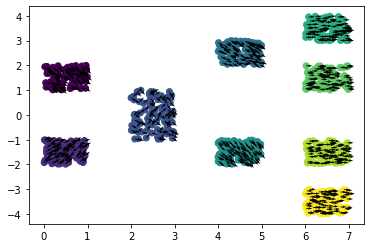

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(data[:,0], data[:,1], c = labels)
plt.quiver(data[:,0],data[:,1], flow[:,0], flow[:,1])

In [ ]:
X = torch.tensor(data)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_8721/588474699.py:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  x_smoothness = (x_vecs.T @ L @ x_vecs) #/ torch.linalg.norm(x_vecs)**2


EPOCH 0. Loss 40.44548034667969. Flow strength 4.999989986419678. Weight of flow 0.5 Heatmap of P embedding is 


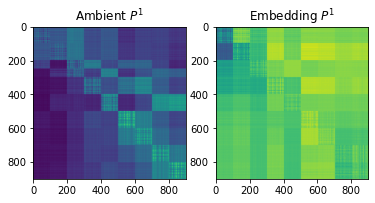

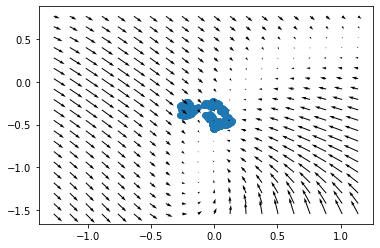

  5%|▌         | 100/2000 [00:23<06:37,  4.78it/s]

EPOCH 100. Loss 40.736541748046875. Flow strength 4.999014377593994. Weight of flow 0.5 Heatmap of P embedding is 


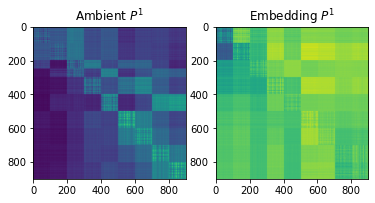

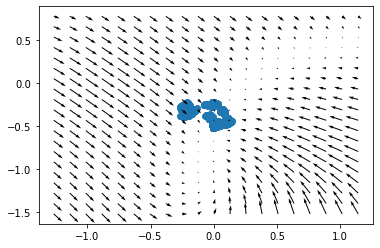

 10%|█         | 200/2000 [00:51<08:16,  3.62it/s]

EPOCH 200. Loss 40.752201080322266. Flow strength 4.998060703277588. Weight of flow 0.5 Heatmap of P embedding is 


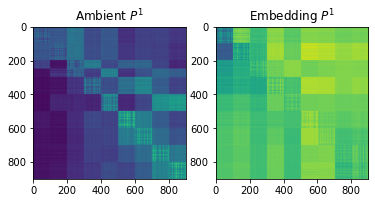

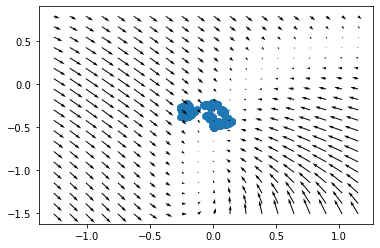

 15%|█▌        | 300/2000 [01:20<07:49,  3.62it/s]

EPOCH 300. Loss 41.1901969909668. Flow strength 4.997125625610352. Weight of flow 0.5 Heatmap of P embedding is 


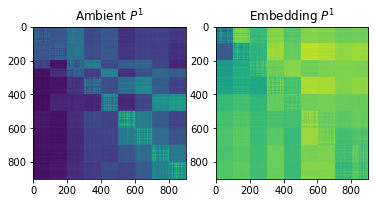

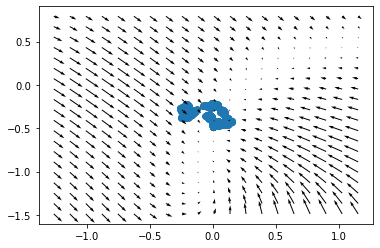

 20%|██        | 400/2000 [01:48<07:20,  3.63it/s]

EPOCH 400. Loss 41.192012786865234. Flow strength 4.996257305145264. Weight of flow 0.5 Heatmap of P embedding is 


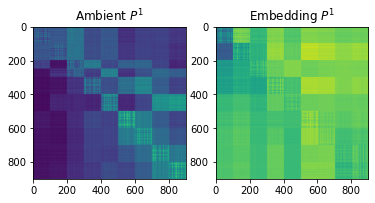

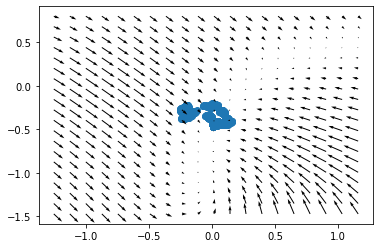

 25%|██▌       | 500/2000 [02:11<05:12,  4.80it/s]

EPOCH 500. Loss 40.73721694946289. Flow strength 4.9952712059021. Weight of flow 0.5 Heatmap of P embedding is 


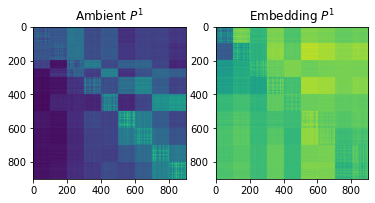

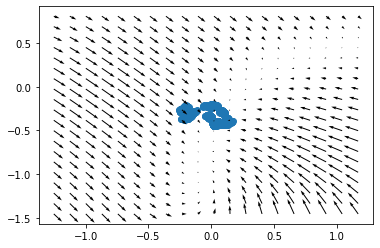

 30%|███       | 600/2000 [02:33<06:19,  3.69it/s]

EPOCH 600. Loss 39.612728118896484. Flow strength 4.993934631347656. Weight of flow 0.5 Heatmap of P embedding is 


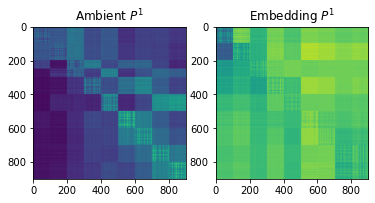

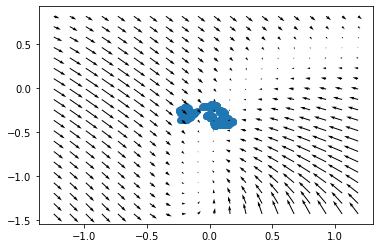

 35%|███▌      | 700/2000 [02:55<04:28,  4.85it/s]

EPOCH 700. Loss 38.770790100097656. Flow strength 4.992349147796631. Weight of flow 0.5 Heatmap of P embedding is 


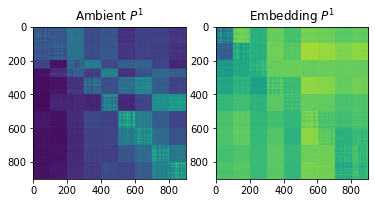

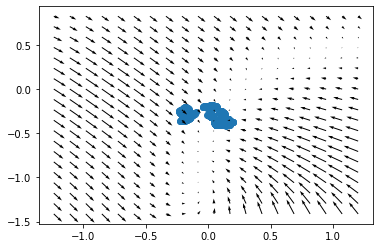

 40%|████      | 800/2000 [03:17<04:07,  4.85it/s]

EPOCH 800. Loss 38.51691818237305. Flow strength 4.990767478942871. Weight of flow 0.5 Heatmap of P embedding is 


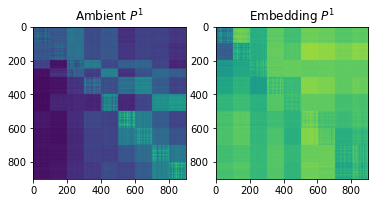

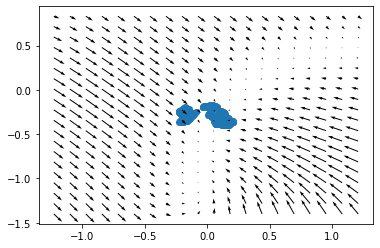

 45%|████▌     | 900/2000 [03:39<03:46,  4.85it/s]

EPOCH 900. Loss 38.54780578613281. Flow strength 4.989330768585205. Weight of flow 0.5 Heatmap of P embedding is 


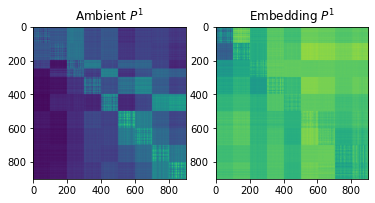

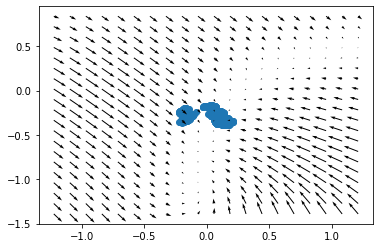

 50%|█████     | 1000/2000 [04:01<03:26,  4.85it/s]

EPOCH 1000. Loss 38.60588455200195. Flow strength 4.988003730773926. Weight of flow 0.5 Heatmap of P embedding is 


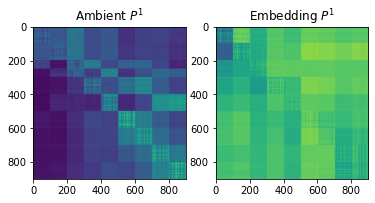

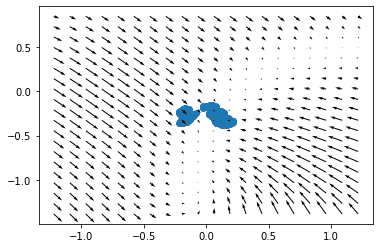

 51%|█████     | 1011/2000 [04:04<03:31,  4.67it/s]

In [ ]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15,device=device)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=1000)